In [1]:
from __future__ import division

import subprocess,os,sys, pdb

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from astropy.table import Table, hstack, vstack
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import swap
from swap_helper_functions import *

/home/oxymoronic/.local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
def find_indices(x, y):
    """
    Find the index of every element of y in x 
    """
    # indices that would sort x (length x)
    index = np.argsort(x)

    sorted_x = x[index]

    # index of every element of y in sorted x (length y)
    # can't plug this into either x or y: 
    # it's too short for x (being length y) and it's x's indices
    # which are too large for y
    sorted_index = np.searchsorted(sorted_x, y)

    # this returns the value of "index" at each index, "sorted_index"
    # so if sorted_index = [273404, 273405, ...]
    # you'll get the value in "index" at THOSE indices
    # since "index" is itself a list of indices, you're actually getting
    # "unsorted" indices in x that correspond to matching values in y
    # (length y) ; x[yindex] = matching values in y
    yindex = np.take(index, sorted_index)
    mask = x[yindex] != y

    result = np.ma.array(yindex, mask=mask)

    return result

In [3]:
###############################################################################
#   CALCULATE CONFUSION MATRIX FOR EACH DAY OF SWAP RUN
###############################################################################
def calculate_confusion_matrix(predicted_yes, predicted_not, subjects, 
                                smooth_or_not=True, gz_kind='raw'):

    ind1 = find_indices(subjects['SDSS_id'], predicted_yes['zooid'])
    gz2_yes = subjects[ind1]

    ind2 = find_indices(subjects['SDSS_id'], predicted_not['zooid'])
    gz2_not = subjects[ind2]
        

    value = int(smooth_or_not)
    opp_value = int(1-value)
        
    mask = (gz2_yes['GZ2_%s'%gz_kind] == value)
    tps_ids = gz2_yes['asset_id'][mask].filled()

    mask = (gz2_yes['GZ2_%s'%gz_kind] == opp_value)
    fps_ids = gz2_yes['asset_id'][mask].filled()

    mask = (gz2_not['GZ2_%s'%gz_kind] == opp_value)
    tns_ids = gz2_not['asset_id'][mask].filled()

    mask = (gz2_not['GZ2_%s'%gz_kind] == value)
    fns_ids = gz2_not['asset_id'][mask].filled()

    return [tps_ids, fps_ids, tns_ids, fns_ids]

In [4]:
###############################################################################
#   GENERATE SWAP EVAL REPORT
###############################################################################
def generate_SWAP_eval_report(detectedfilelist, rejectedfilelist, subjects, 
                              outname, smooth_or_not=True, write_file=True, 
                              gz_kind='raw'):

    recall, precision, accuracy = [], [], []

    tps_, fps_, tns_, fns_ = [], [], [], []
    
    for dfile, rfile in zip(detectedfilelist, rejectedfilelist):
        
        predicted_yes = fetch_classifications(dfile)
        predicted_not = fetch_classifications(rfile)

        asset_ids_matrix = calculate_confusion_matrix(predicted_yes, predicted_not, 
                                                      subjects, 
                                                      smooth_or_not, gz_kind)
        tps, fps, tns, fns = asset_ids_matrix
        tps, fps, tns, fns = len(tps), len(fps), len(tns),len(fns)
        tps_.append(tps)
        fps_.append(fps)
        tns_.append(tns)
        fns_.append(fns)

        if tps:
            recall.append( tps/(fns+tps) )
            precision.append( tps/(fps+tps) )
            accuracy.append( (tps+tns)/(tps+fps+tns+fns) )  
        else:
            recall.append(0.)
            precision.append(0.)
            accuracy.append(0.)    
    
            
    if write_file:
        evaluation = Table(data=(tps_, fps_, tns_, fns_, accuracy, precision, recall), 
                           names=('tps', 'fps', 'tns', 'fns', 'accuracy','precision','recall'))
        evaluation.write('GZXevalution_%s.txt'%(outname), format='ascii')

    return [accuracy, precision, recall], asset_ids_matrix


In [5]:
def plot_GZX_evaluation(axes, num_days, accuracy, precision, recall, 
                        total_retired, smooth_or_not=True):

    days = np.arange(num_days)

    axes.plot(days, accuracy, c='r', label='Accuracy')
    axes.plot(days, precision, c='g', label='Precision')
    axes.plot(days, recall, c='b', label='Recall')
    axes.legend(loc='best')

    axes.set_xlim(0,num_days)
    axes.set_ylim(0.5, 1.0)
    
    if smooth_or_not:
        axes.set_title('SMOOTH or NOT (%i)'%total_retired)
    else:
        axes.set_title('FEATURED or NOT (%i)'%total_retired)      

    axes.set_xlabel('Days in GZ2 project',fontsize=16,fontweight='bold')
    axes.set_ylabel('Per cent',fontsize=16,fontweight='bold')


In [ ]:
def compare_evaluation_plots(config1, config2, gz_kind1, gz_kind2):
    
    fig = plt.figure(figsize=(16,8))

    i=0
    for config, gz_kind in zip([config1, config2], [gz_kind1, gz_kind2]):
        
        outname = config[len('update_'):-len('.config')]+'_'+gz_kind
        
        params = fetch_parameters(config)
        days = fetch_num_days(params)
        
        
        if 'flipfeature' in config:
            smooth_or_not=False
        else:
            smooth_or_not=True

        
        try:    
            report = Table.read('GZXevalution_%s.txt'%outname,format='ascii')
            
            recall = report['recall']
            accuracy = report['accuracy']
            precision = report['precision']
            
            row = report[-1]
            total_retired = sum([row['tps'], row['fps'], row['tns'], row['fns']])
                        
        except:            
            #meta = swap.read_pickle(params['metadatafile'], 'storage')
            #subjects = meta.subjects
            subjects = Table.read('metadata_ground_truth_labels.fits')
                
            detectedfilelist = fetch_filelist(params, kind='detected')
            rejectedfilelist = fetch_filelist(params, kind='rejected')
                        
            evaluation, matrix = generate_SWAP_eval_report(detectedfilelist,rejectedfilelist, 
                                                           subjects, outname, smooth_or_not,
                                                           gz_kind=gz_kind)
            
            accuracy, precision, recall = evaluation
            total_retired = 0.
            for m in matrix:
                total_retired += len(m)

        
        ax = fig.add_subplot(121+i)
        ax.grid(linestyle='dotted',linewidth=.5)
        plot_GZX_evaluation(ax, days, accuracy, precision, recall, 
                            total_retired, smooth_or_not)
        i+=1 
                
    #plt.savefig("GZX_evaluation_%s.png"%outfile)
    plt.show()
    plt.close()

Fetching list of detected files created by GZX...
Fetching list of rejected files created by GZX...
Fetching list of detected files created by GZX...
Fetching list of rejected files created by GZX...


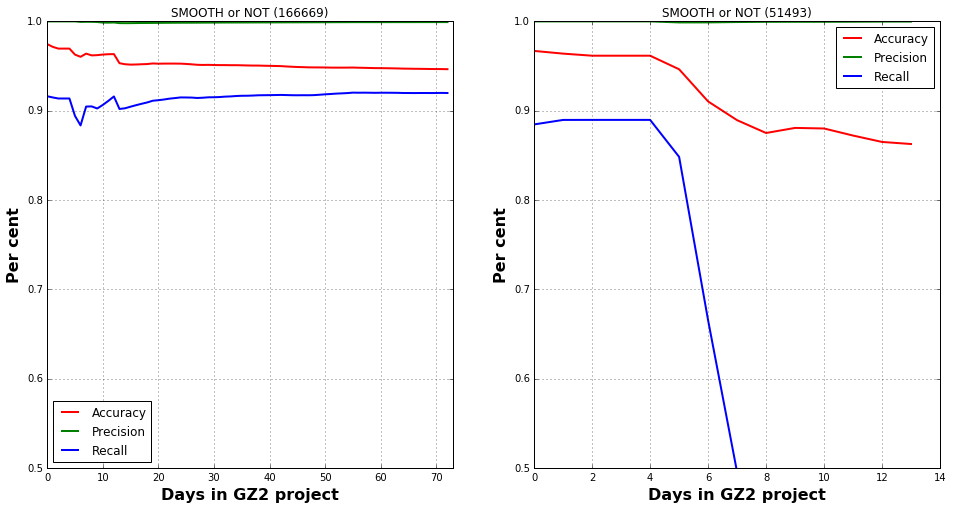

In [ ]:
filenames1 = {'S_featornot':'update_sup_0.5_trainfirst_flipfeature2b.config',
             'S_smoothornot':'update_sup_0.5_trainfirst_standard2.config',
             'SU_featornot':'update_sup_unsup_0.5_trainfirst_flipfeature2b.config',
             'SU_smoothornot':'update_sup_unsup_0.5_trainfirst_standard2.config',
             'S_featornot_p5':'update_sup_PLPD5_p5_flipfeature2b.config',
             'S_smoothornot_p5':'update_sup_PLPD5_p5_standard2.config'}

filenames2 = filenames1

gz_kinds = {'raw': 'raw', 'weighted': 'weighted', 'debiased':'debiased'}

interact(compare_evaluation_plots, config1=filenames1, config2=filenames2, 
         gz_kind1=gz_kinds, gz_kind2=gz_kinds);

In [22]:
def plot_flipfloppers(axes, xaxis, yaxis, subjects, indices, axes_labels, 
                      subject_labels, colors, smooth_or_not=True):
    
    if xaxis in subjects.colnames and yaxis in subjects.colnames:
        
        if len(indices) > 1: # if there are multiple sets of indices... 
            for i, ind in enumerate(indices):
                axes.scatter(subjects[xaxis][ind], subjects[yaxis][ind],
                             color=colors[i], marker='.', label=subject_labels[i], alpha=0.5)
        else:
            axes.scatter(subjects[xaxis][indices], subjects[yaxis][indices],
                            color=colors, marker='.', label=subject_labels, alpha=0.5)            
            
        if smooth_or_not:
            axes.set_title('SMOOTH or NOT')
        else:
            axes.set_title('FEATURED or NOT')
        axes.set_xlabel(axes_labels[0])
        axes.set_ylabel(axes_labels[1])
        axes.set_xlim(-0.2, 1.2)
        axes.set_ylim(-0.2, 1.2)
        
    else:
        print "%s and/or %s are not column names in the catalog"%(xaxis, yaxis)

In [8]:
big_catalog = Table.read('../GZ2ASSETS_NAIR_MORPH_MAIN_SDSS.fits')

In [40]:
xaxis = 't01_smooth_or_features_a02_features_or_disk_fraction'
yaxis = 't01_smooth_or_features_a01_smooth_fraction'

#xaxis = 't01_smooth_or_features_a02_features_or_disk_debiased'
#yaxis = 't01_smooth_or_features_a01_smooth_debiased'

axes_labels = ['f_features', 'f_smooth']


#xaxis = 'REDSHIFT'
#yaxis = 'PETROMAG_R'

#axes_labels = [xaxis, yaxis]

def compare_distributions(config1, config2, category):

    
    fig = plt.figure(figsize=(16,8))

    i=0
    for config in [config1, config2]:
        
        outname = config[len('update_'):-len('.config')]
        
        # open the config file and get the parameters
        params = fetch_parameters(config)
        days = fetch_num_days(params)
        
        
        if 'flipfeature' in config:
            smooth_or_not=False
        else:
            smooth_or_not=True
        
        # grab list of files for both detected/rejected subjects
        detectedfilelist = fetch_filelist(params, kind='detected')
        rejectedfilelist = fetch_filelist(params, kind='rejected')
        
        detected = [detectedfilelist[-1]]
        rejected = [rejectedfilelist[-1]]

        # open the metadata file for this run
        #meta = swap.read_pickle(params['metadatafile'], 'storage')
        #subjects = meta.subjects
        subjects = Table.read('metadata_ground_truth_labels.fits')
            
        # the big catalog of everything should already be opened
        # stack these into the "fullcat"
        fullcat = hstack([subjects,big_catalog])
    
        evaluation, asset_ids_matrix = generate_SWAP_eval_report(detected, rejected, fullcat, outname, 
                                                      smooth_or_not=False, write_file=True,
                                                      gz_kind='raw')

        tps, fps, tns, fns = asset_ids_matrix        
        tps, fps, tns, fns = tps-1, fps-1, tns-1, fns-1
        
        #"""
        ax = fig.add_subplot(121+i)
               
            
        colors = ['darkmagenta', 'plum', 'firebrick', 'midnightblue']

            
        if category == 'all':
            subject_labels = ['True Positives', 'False Positives', 
                              'True Negatives', 'False Negatives']
            plot_flipfloppers(ax, xaxis, yaxis, fullcat, asset_ids_matrix, axes_labels, 
                              subject_labels, colors)

            
        elif category in ['tps', 'fps','tns','fns']:
            
            if category == 'tps': 
                j = 0
                cat = [tps] 
                subject_label = ['True Positives (%i)'%len(cat)]
                
            elif category == 'fps': 
                j = 1
                cat = [fps]
                subject_label = ['False Positives (%i)'%len(cat)]
                
            elif category == 'tns': 
                j = 2
                cat = [tns]
                subject_label = ['True Negatives (%i)'%len(cat)]

            elif category == 'fns': 
                j = 3
                cat = [fns]
                subject_label = ['False Negatives (%i)'%len(cat)]        
                
            plot_flipfloppers(ax, xaxis, yaxis, fullcat, cat, axes_labels, 
                              subject_label, colors[j])
            
        elif category == 'correct':
            subject_labels = ['True Positives (%i)'%len(tps), 'True Negatives (%i)'%len(tns)]
            
            plot_flipfloppers(ax, xaxis, yaxis, fullcat, [tps, tns], axes_labels, 
                              subject_labels, colors[::2], smooth_or_not)
            
        elif category == 'incorrect':
            
            subject_labels = ['False Positives (%i)'%len(fps), 'False Negatives (%i)'%len(fns)]

            plot_flipfloppers(ax, xaxis, yaxis, fullcat, [fps, fns], axes_labels, 
                              subject_labels, colors[::-2], smooth_or_not)      
            
        ax.legend(loc='best')           
        i+=1    
    
    
    plt.show()
    plt.close()
    #"""

Fetching list of detected files created by GZX...
Fetching list of rejected files created by GZX...
Fetching list of detected files created by GZX...
Fetching list of rejected files created by GZX...


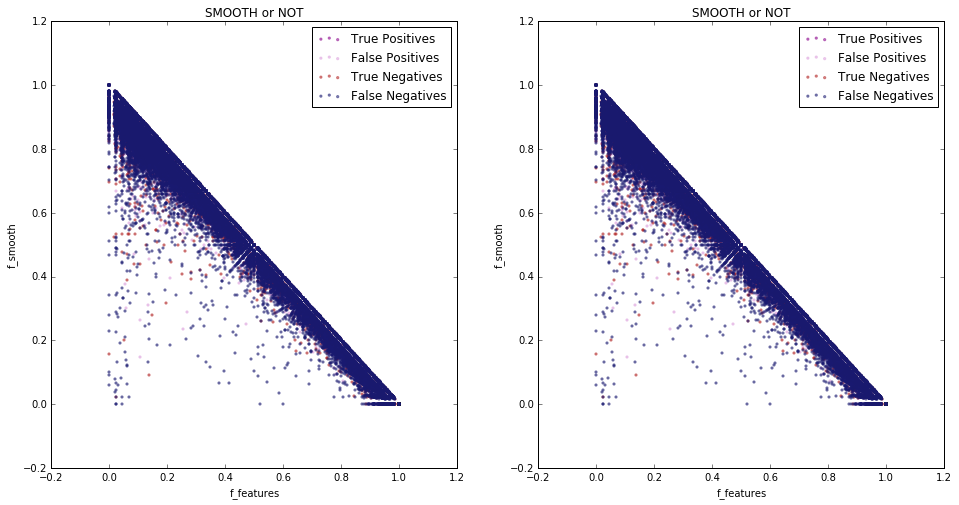

In [41]:
filenames1 = {'S_featornot':'update_sup_0.5_trainfirst_flipfeature2.config',
             'S_smoothornot':'update_sup_0.5_trainfirst_standard2.config',
             'SU_featornot':'update_sup_unsup_0.5_trainfirst_flipfeature2.config',
             'SU_smoothornot':'update_sup_unsup_0.5_trainfirst_standard2.config',
             'S_featornot_p5':'update_sup_PLPD5_p5_flipfeature2.config',
             'S_smoothornot_p5':'update_sup_PLPD5_p5_standard2.config'}

filenames2 = filenames1

categories = {'True Positives':'tps','False Positives':'fps',
              'True Negatives':'tns','False Negatives':'fns', 
              'All':'all', 'Correct':'correct', 'Incorrect':'incorrect'}

interact(compare_distributions, config1=filenames1, config2=filenames2, category=categories);